# Gender in the Library of Congress Subject Headings

## Imports

In [1]:
import pickle as pk
import random
import matplotlib.pyplot as plt 
import numpy as np
import re

## Functions

In [2]:
def getDep(lcsh):
    count = 0
    dep = {}
    for idx, heading in lcsh.items():
        if heading['yearDep'] is not None:
            dep[idx] = heading
            count += 1
    return count, dep


def countTypes(lcsh):
    kinds = {}
    for heading in lcsh.values():
        kind = heading['type']
        if kind in kinds:
            kinds[kind] += 1
        else:
            kinds[kind] = 1
    return kinds

def getSimple(lcsh):
    simple = {}
    simpleTypes = ['Topic', 'Geographic', 'CorporateName', 'FamilyName', 'Title', 
                   'ConferenceName', 'PersonalName']
    for idx, term in lcsh.items():
        if term['type'] in simpleTypes:
            simple[idx] = term
    return simple

def getLCCTerms(lcsh):
    lccTerms = {}
    for idx, term in lcsh.items():
        if term['lcc'] is not None:
            lccTerms[idx] = term
    return lccTerms

def getTimeLine(lcsh):
    years = {}
    for term in lcsh.values():
        year = term['yearNew'][:4]
        if year in years:
            years[year] += 1
        else:
            years[year] = 1
    return years

def equivalent_gen(mHead, wHead):
    women = ['women','woman', 'girl', 'female']
    men = ['men','man', 'boy', 'male']
    pairs = []
    skeleton = []
    mTerms = [t['heading'] for t in mHead.values()]
    wTerms = [t['heading'] for t in wHead.values()]
    for i in range(len(women)):
        replaced = {}
        wordW = women[i]
        wordM = men[i]
        for i, term in enumerate(wTerms):
            wTerm = term.lower()
            if wordW in wTerm:
                replaced[wTerm.replace(wordW, '')] = i
        for i, term in enumerate(mTerms):
            mTerm = term.lower()
            if wordM in term:
                mTerm = mTerm.replace(wordM, '')
                if mTerm in replaced.keys():
                    pairs.append((list(mHead.values())[i],list(wHead.values())[replaced[mTerm]]))
                    skeleton.append(term.replace(wordM, '[blank]'))
    return pairs, skeleton


In [3]:
with open('Data/lcsh.pickle', 'rb') as f:
    lcsh = pk.load(f)

In [4]:
simpleLCSH = getSimple(lcsh)
print(f'There are {len(simpleLCSH):,} simple terms')

There are 274,339 simple terms


In [5]:
i = 0
wTerms = {}
with open('women_terms.txt', 'w') as f:
    for idx, term in simpleLCSH.items():
        head = term['heading'].replace('(', '').replace(')', '')
        words = [w.lower() for w in head.split(' ')]
        if ('women' in words
             or 'woman' in words
             or 'girl' in words
             or 'girls' in words 
             or 'female' in words 
             or "women's" in words 
             or "woman's" in words):
            f.write(f'{term['heading']}\n')
            wTerms[idx] = term
            i += 1
print(i)

[term['heading'] for term in wTerms.values() if term['yearDep'] is not None]

2378


['_Bicycle Woman (Fictitious character)',
 '_Pioneer Woman Statue (Ponca City, Okla.)',
 '_African American HIV-positive women',
 '_Indian HIV-positive women',
 '_Hispanic American HIV-positive women',
 '_Power Girl (Fictitious character)',
 '_National Women and Girls in Sports Day',
 '_Wonder Woman (Fictitious character)']

In [6]:
i = 0
mTerms = {}
with open('men_terms.txt', 'w') as f:
    for idx, term in simpleLCSH.items():
        head = term['heading'].replace('(', '').replace(')', '')
        words = [w.lower() for w in head.split(' ')]
        if ('men' in words 
            or 'man' in words 
            or 'boy' in words 
            or 'boys' in words 
            or 'male' in words 
            or "men's" in words 
            or "man's" in words):
            f.write(f'{term['heading']}\n')
            mTerms[idx] = term
            i += 1
print(i)
[term['heading'] for term in mTerms.values() if term['yearDep'] is not None]

554


['_Action Man (Fictitious character)',
 '_Blast Off Boy (Fictitious character)',
 '_African American HIV-positive men',
 '_Bat Boy (Fictitious character)',
 '_Iron Man (Fictitious character)',
 '_Animal Man (Fictitious character)',
 '_Astro Boy (Fictitious character)',
 '_Robin the Boy Wonder (Fictitious character)',
 '_Hispanic American HIV-positive men']

## Plots

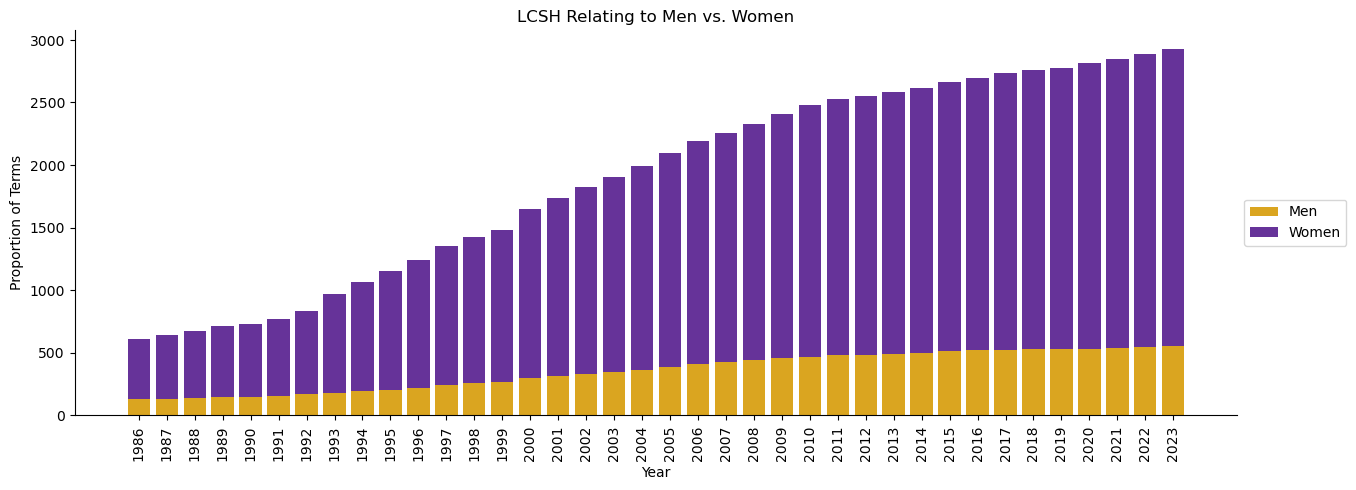

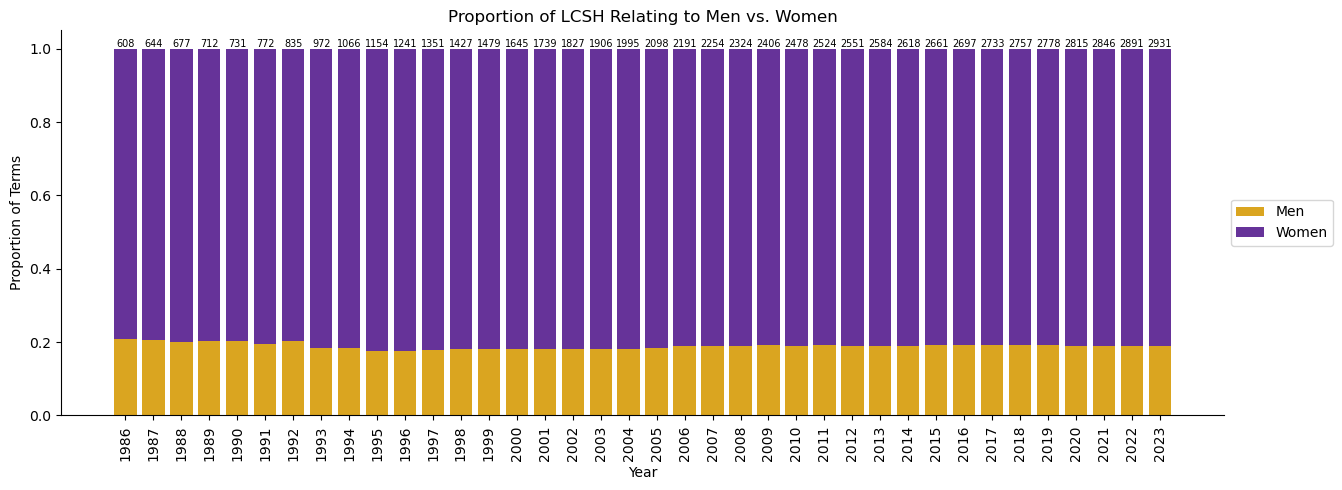

In [7]:
years = [y for y in range(1986, 2024)]
timelineM = {y:0 for y in years}
for term in mTerms.values():
    yearAdded = int(term['yearNew'][:4])
    if yearAdded != 2024:
        timelineM[yearAdded] += 1
timelineW = {y:0 for y in years}
for term in wTerms.values():
    yearAdded = int(term['yearNew'][:4])
    if yearAdded != 2024:
        timelineW[yearAdded] += 1

idx = list(timelineM.keys())
culmW = np.cumsum(list(timelineW.values()))
culmM = np.cumsum(list(timelineM.values()))

width = 0.8
fig, ax = plt.subplots(figsize = (15, 5))
bottom = np.zeros(38)

weight_counts = {
    "Men": culmM,
    "Women": culmW,
}

colours = ['goldenrod', 'rebeccapurple']
i = 0
for lab, weight_count in weight_counts.items():
    p = ax.bar(idx, weight_count, width, label=lab, bottom=bottom, color=colours[i])
    bottom += weight_count
    i += 1

ax.set_title("LCSH Relating to Men vs. Women")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('Year')
plt.ylabel('Proportion of Terms')
plt.xticks(idx, rotation=90)
plt.show()


total = [culmW[i]+culmM[i] for i in range(len(culmM))]
propW = [culmW[i]/total[i] for i in range(len(culmW))]
propM = [culmM[i]/total[i] for i in range(len(culmM))]


fig, ax = plt.subplots(figsize = (15, 5))
bottom = np.zeros(38)

weight_counts = {
    "Men": propM,
    "Women": propW,
}

colours = ['goldenrod', 'rebeccapurple']
i = 0
for lab, weight_count in weight_counts.items():
    p = ax.bar(idx, weight_count, width, label=lab, bottom=bottom, color=colours[i])
    bottom += weight_count
    i += 1

ax.set_title("Proportion of LCSH Relating to Men vs. Women")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.spines[['right', 'top']].set_visible(False)

for i in range(len(total)):
    plt.text(idx[i], 1.005, total[i], ha = 'center', fontsize=7)

plt.xlabel('Year')
plt.ylabel('Proportion of Terms')
plt.xticks(idx, rotation=90)

plt.show()

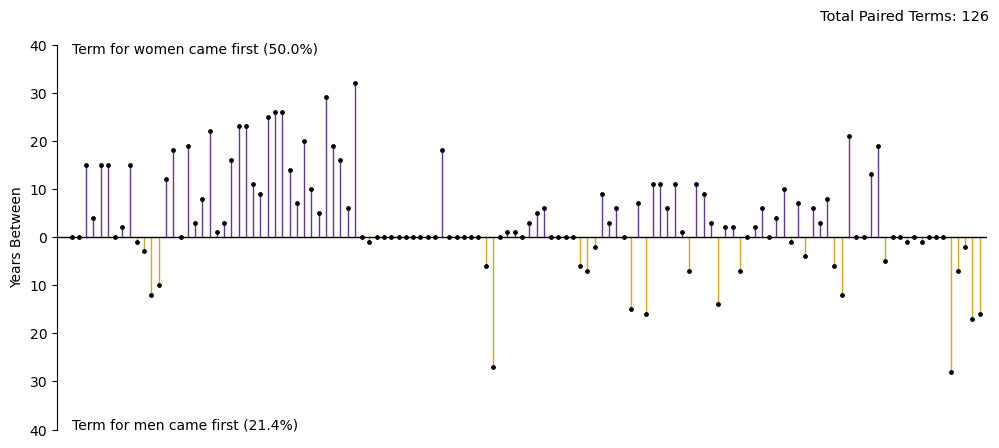

In [8]:
pairs, skeleton = equivalent_gen(mTerms, wTerms)
with open('pairedTerms.txt', 'w') as f:
    for pair in pairs:
        f.write(f'{pair[1]['heading']} ({pair[1]['yearNew'][:4]}), {pair[0]['heading']} ({pair[0]['yearNew'][:4]})\n' )
x = [i for i in range(len(pairs))]
y = [int(m['yearNew'][:4]) - int(w['yearNew'][:4]) for m,w in pairs]
base = [0 for i in range(len(pairs))]
fig, ax = plt.subplots(figsize = (12, 5))
ax.spines[['bottom', 'top', 'right']].set_visible(False)
firstF, firstM = 0, 0
for i in range(len(y)):
    if y[i] < 0:
        plt.plot([x[i], x[i]], [0, y[i]], color="goldenrod", linewidth=1, zorder=-1)
        firstM += 1
    if y[i] > 0:
        plt.plot([x[i], x[i]], [0, y[i]], color="rebeccapurple", linewidth=1, zorder=-1)
        firstF += 1
plt.text(0, 39, f'Term for women came first ({(firstF/len(y))*100:.1f}%)', verticalalignment='center')
plt.text(0, -39, f'Term for men came first ({firstM/len(y)*100:.1f}%)', verticalalignment='center')

plt.plot([-2] + x + [126], [0] + base + [0], color='black', linewidth=1)
plt.scatter(x, y, c='black', marker='o', s=6, zorder=1)
plt.xticks([])
plt.margins(0)
plt.axis([-2, 126, -40, 40])
plt.yticks([i for i in range(-40, 41, 10)], [abs(i) for i in range(-40, 41, 10)])
plt.ylabel('Years Between')
plt.text(103, 45, f'Total Paired Terms: {len(y)}', fontsize=10.5)
plt.show()